# Healthcare Data Acquisition

The goal of this notebook is to help with the overall wildland fire analysis for Indianapolis, Indiana, by loading and exploring all the healthcare data.

The notebook will also combine all the data into a single dataframe and save it for further analysis. 

## License

The code lies under the standard [MIT licence](./LICENSE).

## Setup

In [1]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## State-Level Chronic Respiratory Illness Data

[Global Burden of Disease (GBD)](https://vizhub.healthdata.org/gbd-results/)

The data contained in this IHME (Institute for Health Metrics and Evaluation: Homepage) dashboard can be used to extract respiratory illness-related raw counts and rates (per 10,000) for incidence (new cases), prevalence (total cases), and deaths, from 1999-2021. 
The lowest level of granularity is state-level (Indiana).

From the dashboard, we can get access to the following dataset:
- IHME-GBD_2021_DATA-<uuid>.csv:
This CSV file contains all the aggregated data that is obtained from the dashboard.
    - `Measure`: (Deaths, Prevalence, Incidence)
    - `Metric`: (Percent, Rate, Number)
    - `Year`
    - `Value`
    - `Upper`
    - `Lower`

The datasets can be downloaded from the dashboard in zipped CSV les. The data is governed by the 
[IHME FREE-OF-CHARGE NON-COMMERCIAL USER AGREEMENT](https://www.healthdata.org/Data-tools-practices/data-practices/ihme-free-charge-non-commercial-user-agreement).

In [2]:
#########
#
#    CONSTANTS
#
IHME_STATE_DATA_PATH = 'data/IHME-GBD_2021_DATA-23c5e5a1-1.csv'

In [3]:
ihme_state_data_df = pd.read_csv(IHME_STATE_DATA_PATH)

In [71]:
IHME_STATE_RELEVANT_COLUMNS = [
    # 'measure_id', 
    'measure_name', 
    # 'location_id', # Always 537
    # 'location_name', # Always Indiana
    # 'sex_id', # Always 3
    # 'sex_name', # Always Both
    # 'age_id',  # Always 22
    # 'age_name', # Always All Ages
    # 'cause_id', 
    'cause_name', 
    # 'metric_id',
    'metric_name', 
    'year', 
    'val', 
    # 'upper', # Currently not used
    # 'lower', # Currently not used
]

In [72]:
ihme_state_data_df = ihme_state_data_df[IHME_STATE_RELEVANT_COLUMNS]
ihme_state_data_df.head(2)

,measure_name,cause_name,metric_name,year,val
0,Deaths,Chronic respiratory diseases,Number,1981,1760.687643
1,Deaths,Chronic respiratory diseases,Percent,1981,0.037321


In [73]:
print(ihme_state_data_df['measure_name'].unique())
print(ihme_state_data_df['cause_name'].unique())
print(ihme_state_data_df['metric_name'].unique())

['Deaths' 'Prevalence' 'Incidence']
['Chronic respiratory diseases' 'Chronic obstructive pulmonary disease'
 'Asthma']
['Number' 'Percent' 'Rate']


In [83]:
ihme_state_data_rates_df = ihme_state_data_df[ihme_state_data_df['metric_name'] == 'Rate'].drop(columns=['metric_name'])
ihme_state_data_numbers_df = ihme_state_data_df[ihme_state_data_df['metric_name'] == 'Number'].drop(columns=['metric_name'])

In [ ]:
# Pivot the data to have the years as index
ihme_state_data_rates_df = ihme_state_data_rates_df.pivot(index='year', columns=['measure_name', 'cause_name'], values='val')
ihme_state_data_numbers_df = ihme_state_data_numbers_df.pivot(index='year', columns=['measure_name', 'cause_name'], values='val')

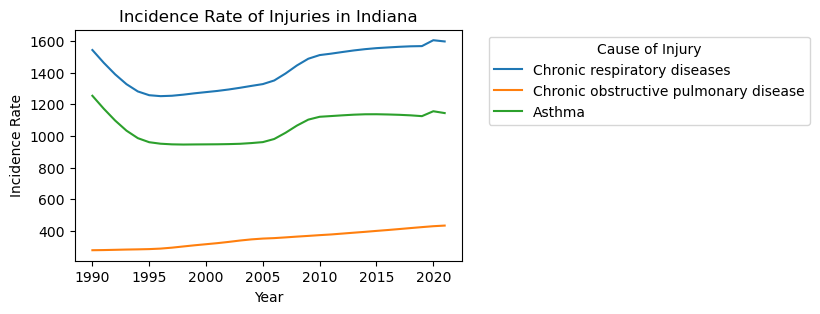

In [90]:
# Plot the incidence rates of the different causes of injury
fig = plt.figure(figsize=(5, 3))
ihme_state_data_rates_df['Incidence'].plot(ax = plt.gca())
plt.xlabel('Year')
plt.ylabel('Incidence Rate')
plt.title('Incidence Rate of Injuries in Indiana')
plt.legend(title='Cause of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')

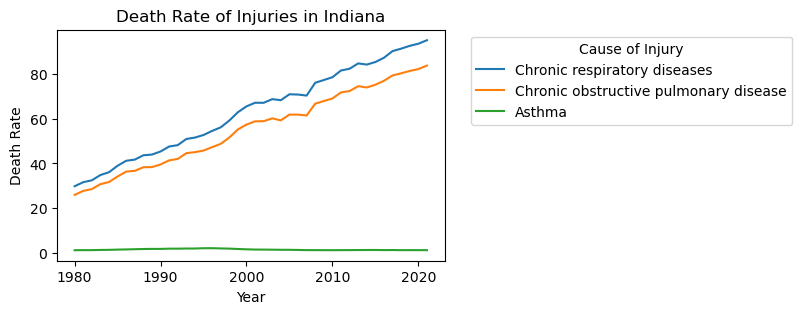

In [ ]:
# Plot the death rates of the different causes of injury
fig = plt.figure(figsize=(5, 3))
ihme_state_data_rates_df['Deaths'].plot(ax = plt.gca())
plt.xlabel('Year')
plt.ylabel('Death Rate')
plt.title('Death Rate of Injuries in Indiana')
plt.legend(title='Cause of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')

As it turns out, while asthma is more prevalent among patients of Respiratory illnesses, COPD seems to be consistently responsible for most of the Respiratory Illness-related deaths in Indiana. 



In [ ]:
# The rates and numbers are proportional to each other, so we can use the rates dataframes for the analysis
# Separate out the relevant dataframes to be used for the combined dataframe
ihme_state_data_rates_incidence_df = ihme_state_data_rates_df['Incidence']
ihme_state_data_rates_deaths_df = ihme_state_data_rates_df['Deaths']

## Marion County Health Outcomes Data

[MCPHD Environmental Public Health Tracking Dashboard](https://marionhealth.org/explore-data/)

The data contained in this dashboard tracks asthma and COPD-related ED (Emergency Department) visits and hospitalizations from 2016 - 2023. 
The main reason for the limited window of data is the fact that Marion County was only recently awarded a grant by the CDC (Centers for Disease Control and Prevention), in 2022. 

From the dashboard, we can get access to the following datasets:
- Asthma_ED_Yearly.csv / COPD_ED_Yearly.csv:
Tracks the ED visits for asthma from 2018 - 2023.
    - `Year`
    - `ObservedEvents`
    - `CrudeRate`
    - `AgeAdjustedRatePer10K`
    - `AgeAdjustedLowerCL`
    - `AgeAdjustedUpperCL`

- Asthma_Hosp_Yearly.csv / COPD_Hosp_Yearly.csv:
Tracks the Hospitalizations for asthma from 2016-2018
    - `Year`
    - `ObservedEvents`
    - `CrudeRate`
    - `AgeAdjustedRatePer10K`
    - `LowerCL`
    - `UpperCL`

In [101]:
ASTHMA_COUNTY_ED_PATH = 'data/Asthma_ED_Yearly.csv'
ASTHMA_COUNTY_HOSP_PATH = 'data/Asthma_Hosp_Yearly.csv'

COPD_COUNTY_ED_PATH = 'data/COPD_ED_Yearly.csv'
COPD_COUNTY_HOSP_PATH = 'data/COPD_Hosp_Yearly.csv'

In [102]:
asthma_county_ed_df = pd.read_csv(ASTHMA_COUNTY_ED_PATH)
asthma_county_hosp_df = pd.read_csv(ASTHMA_COUNTY_HOSP_PATH)

copd_county_ed_df = pd.read_csv(COPD_COUNTY_ED_PATH)
copd_county_hosp_df = pd.read_csv(COPD_COUNTY_HOSP_PATH)

In [103]:
COUNTY_ED_RELEVANT_COLUMNS = [
    'Year',
    # 'ObservedEvents', # Number of events will not be used
    # 'CrudeRate', # Crude rate will not be used
    'AgeAdjustedRatePer10K',
    # 'AgeAdjustedLowerCL', # Currently not used
    # 'AgeAdjustedUpperCL' # Currently not used
]

COUNTY_HOSP_RELEVANT_COLUMNS = [
    'YearAdmitted',
    # 'ObservedEvents', # Number of events will not be used
    # 'CrudeRate', # Crude rate will not be used
    'AgeAdjustedRatePer10K',
    # 'LowerCL', # Currently not used
    # 'UpperCL' # Currently not used
]

In [104]:
asthma_county_ed_df = asthma_county_ed_df[COUNTY_ED_RELEVANT_COLUMNS]
asthma_county_hosp_df = asthma_county_hosp_df[COUNTY_HOSP_RELEVANT_COLUMNS]

copd_county_ed_df = copd_county_ed_df[COUNTY_ED_RELEVANT_COLUMNS]
copd_county_hosp_df = copd_county_hosp_df[COUNTY_HOSP_RELEVANT_COLUMNS]

In [105]:
# In IHME and FRED, the rate is calculated per 100,000 people.
# In the county data, the rate is calculated per 10,000 people. Hence, we need to convert the county data to per 100,000 people.
asthma_county_ed_df['AgeAdjustedRatePer100K'] = asthma_county_ed_df['AgeAdjustedRatePer10K'] * 10
asthma_county_ed_df.drop(columns=['AgeAdjustedRatePer10K'], inplace=True)
asthma_county_hosp_df['AgeAdjustedRatePer100K'] = asthma_county_hosp_df['AgeAdjustedRatePer10K'] * 10
asthma_county_hosp_df.drop(columns=['AgeAdjustedRatePer10K'], inplace=True)

copd_county_ed_df['AgeAdjustedRatePer100K'] = copd_county_ed_df['AgeAdjustedRatePer10K'] * 10
copd_county_ed_df.drop(columns=['AgeAdjustedRatePer10K'], inplace=True)
copd_county_hosp_df['AgeAdjustedRatePer100K'] = copd_county_hosp_df['AgeAdjustedRatePer10K'] * 10
copd_county_hosp_df.drop(columns=['AgeAdjustedRatePer10K'], inplace=True)

In [106]:
asthma_county_ed_df.head(2)

,Year,AgeAdjustedRatePer100K
0,2018,630.8
1,2019,682.4


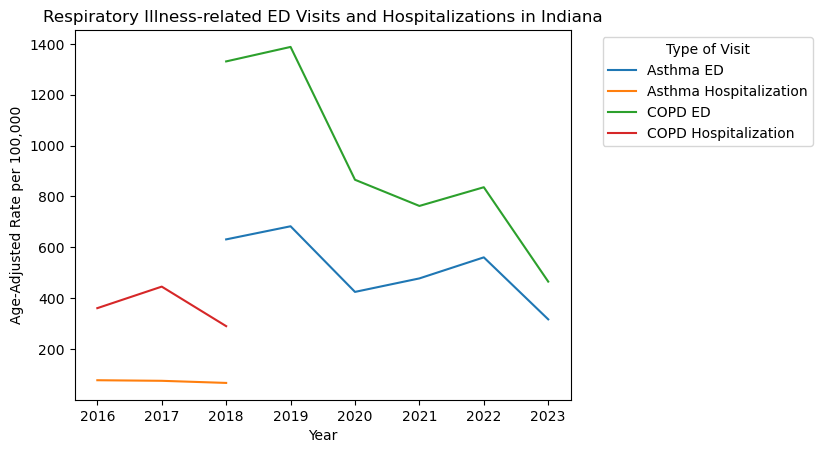

In [107]:
plt.plot(asthma_county_ed_df['Year'], asthma_county_ed_df['AgeAdjustedRatePer100K'], label='Asthma ED')
plt.plot(asthma_county_hosp_df['YearAdmitted'], asthma_county_hosp_df['AgeAdjustedRatePer100K'], label='Asthma Hospitalization')
plt.plot(copd_county_ed_df['Year'], copd_county_ed_df['AgeAdjustedRatePer100K'], label='COPD ED')
plt.plot(copd_county_hosp_df['YearAdmitted'], copd_county_hosp_df['AgeAdjustedRatePer100K'], label='COPD Hospitalization')
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 100,000')
plt.title('Respiratory Illness-related ED Visits and Hospitalizations in Indiana')
plt.legend(title='Type of Visit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Weirdly enough, as the plots suggest, Marion County has tracked hospitalizations and ED visits for different date ranges. 
Since hospitalizations have been tracked only for 3 years, there is not much analysis possible with it.

We will be saving all ED visit and hospitalization data in the combined dataframe, however, we will use only ED visit data for any kind of analysis. 

In [108]:
# Rename the Year column to match the IHME data
asthma_county_hosp_df.rename(columns={'YearAdmitted': 'Year'}, inplace=True)
copd_county_hosp_df.rename(columns={'YearAdmitted': 'Year'}, inplace=True)

## Marion Age-Adjusted Premature Death Rate

FRED is an online database that has more than 800,000 time series datasets from various sources. 
From this database, we will be utilizing the ‘Age-adjusted premature death rate’ for Marion County.

We can access the following dataset from the link:
- CDC20N2UAA018097.csv:
This CSV file contains all the aggregated data that is obtained from the link.
    - `Year`
    - `Count`

In [56]:
PREMATURE_DEATH_COUNTY_PATH = 'data/CDC20N2UAA018097_Age_Adjusted_Premature_Death_Rate.csv'

In [111]:
premature_death_county_df = pd.read_csv(PREMATURE_DEATH_COUNTY_PATH)
premature_death_county_df['Year'] = pd.to_datetime(premature_death_county_df['DATE']).dt.year
premature_death_county_df.rename(columns={'CDC20N2UAA018097': 'death_rate'}, inplace=True)
premature_death_county_df.drop(columns=['DATE'], inplace=True)

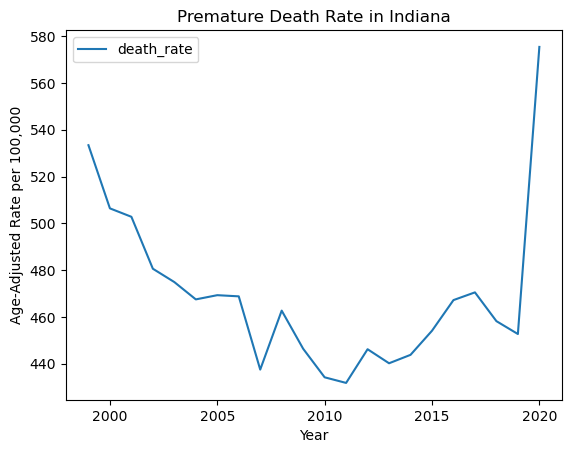

In [115]:
premature_death_county_df.plot(x='Year', y='death_rate')
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 100,000')
plt.title('Premature Death Rate in Indiana')
plt.show()

In [119]:
premature_death_county_df.sort_values(by='Year', ascending=False).head(3)

,death_rate,Year
21,575.4,2020
20,452.7,2019
19,458.2,2018


While the premature death rate had been reducing steadily until 2010, it started increasing at a similar pace post 2010. 
It also seems to have shot up in the year 2020, going from 452.7 to 575.4